# Prepare Dataset for Model Training and Evaluating

# Amazon Customer Reviews Dataset

https://s3.amazonaws.com/amazon-reviews-pds/readme.html

## Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

## Check dependencies setup

In [2]:
%store -r setup_dependencies_passed

try:
    setup_dependencies_passed
except NameError:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN THE PREVIOUS NOTEBOOK ")
    print("You did not install the required libraries.   ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")

if not setup_dependencies_passed:
    print("++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN THE PREVIOUS NOTEBOOK ")
    print("You did not install the required libraries.   ")
    print("++++++++++++++++++++++++++++++++++++++++++++++")
else:
    print("[OK] Dependencies correctly set up")

[OK] Dependencies correctly set up


## Setup notebook

In [4]:
import boto3
import sagemaker
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

In [5]:
!mkdir -p ./tmp
!aws s3 cp 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./tmp/

temp_folder = "tmp"
dataset = "amazon_reviews_us_Digital_Software_v1_00.tsv.gz"
dataset_csv = "amazon_reviews_us_Digital_Software_v1_00_comprehend.csv"

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to tmp/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [6]:
df = pd.read_csv(
    f"{temp_folder}/{dataset}",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

In [7]:
print(f"Shape of dataframe before splitting {df.shape}")

Shape of dataframe before splitting (102084, 15)


In [8]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

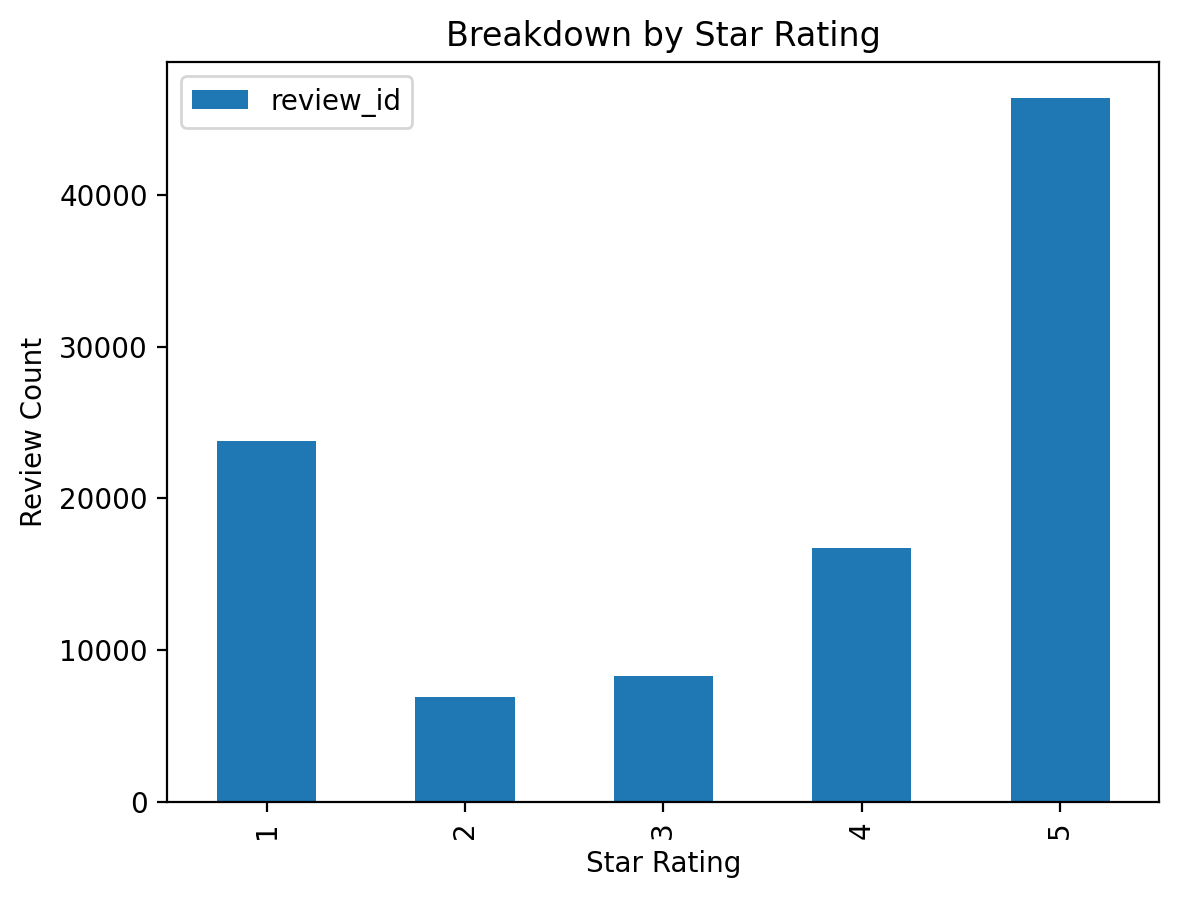

In [9]:
df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

# Balance the Dataset

Para balancear el dataset, primero agrupamos por star_rating, y después seleccionamos un número de muestras:

- o bien valor más bajo de star_rating (_6890)
- o bien se le da un valor fijo para obtener 10_000 por ejemplo

Para este ejercicio vamos a escoger un número limitado de muestras del dataset para agilizar los procesos y abaratar los costes

Observamos el dataset agrupado por `star_rating`

In [10]:
df_grouped_by = df.groupby(["star_rating"]) 
df_grouped_by.sum(numeric_only=True)

,customer_id,product_parent,helpful_votes,total_votes
star_rating,,,,
1,748787926980,12451699865890,151719,179266
2,217714275238,3638933437911,17667,21496
3,255068303491,4374417242699,15685,19995
4,499174433880,9001973235810,20877,28490
5,1327134672859,25500413405050,44612,72126


Obtenemos el valor mínimo

In [11]:
df_grouped_by.size().min()

6890

Reducimos cada agrupación al número de muestras apropiado

In [14]:
# df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced = df_grouped_by.apply(lambda x: x.sample(200).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)

print(f"Shape of balanced dataframe {df_balanced.shape}")

Shape of balanced dataframe (1000, 15)


Observamos de nuevo la dispersión

Text(0, 0.5, 'Review Count')

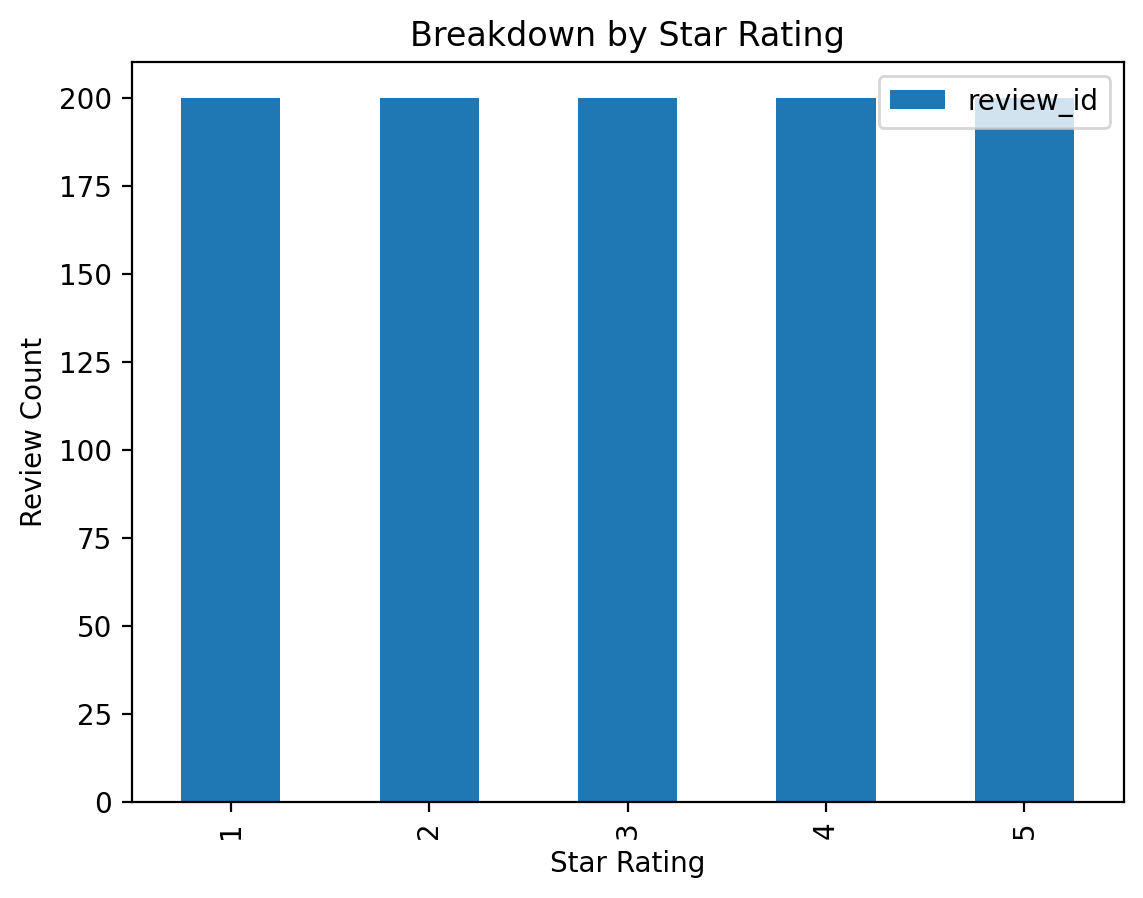

In [15]:
df_balanced[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="Breakdown by Star Rating"
)
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

In [16]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,44524004,R2S4SQWWL5AWM9,B00M9GTJLY,103182180,Intuit Quicken Rental Property Manager 2015,Digital_Software,1,0,0,N,Y,Not Recommend,Does not work well with Windows 8....,2015-06-14
1,US,27145129,R19UAFECW1VFY7,B00B1TGQCA,564044211,Microsoft Office Professional 2013 (1PC/1User),Digital_Software,1,6,6,N,N,Microsoft fixed a product that wasn't broken.,I've been a happy user of MS Office since my t...,2013-11-20
2,US,36245241,R3GZJVOBS77L5Z,B00NG7JVSQ,811978073,TurboTax Deluxe Fed + Efile + State,Digital_Software,1,7,8,N,Y,Intuit Removed Basic Functionality,I have used TurboTax for many years. Unfortuna...,2015-01-10
3,US,47476298,R1ZIOUCFQ6MBP2,B00B1TFFYA,514913291,Microsoft Access 2013 (1PC/1User),Digital_Software,1,2,3,N,Y,Please heed all warnings - nightmare installat...,Wish there was a zero star rating. I had Offi...,2014-03-25
4,US,33858059,R3DSPKLYFRW7IN,B0064PFB9U,232554866,Office Mac Home and Student 2011 - 1PC/1User [...,Digital_Software,1,1,1,N,Y,Don't waste your money on garbage.,I bought and downloaded this and it completely...,2015-03-09


# Split the Data into Train, Validation, and Test Sets

In [17]:
# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["star_rating"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["star_rating"])

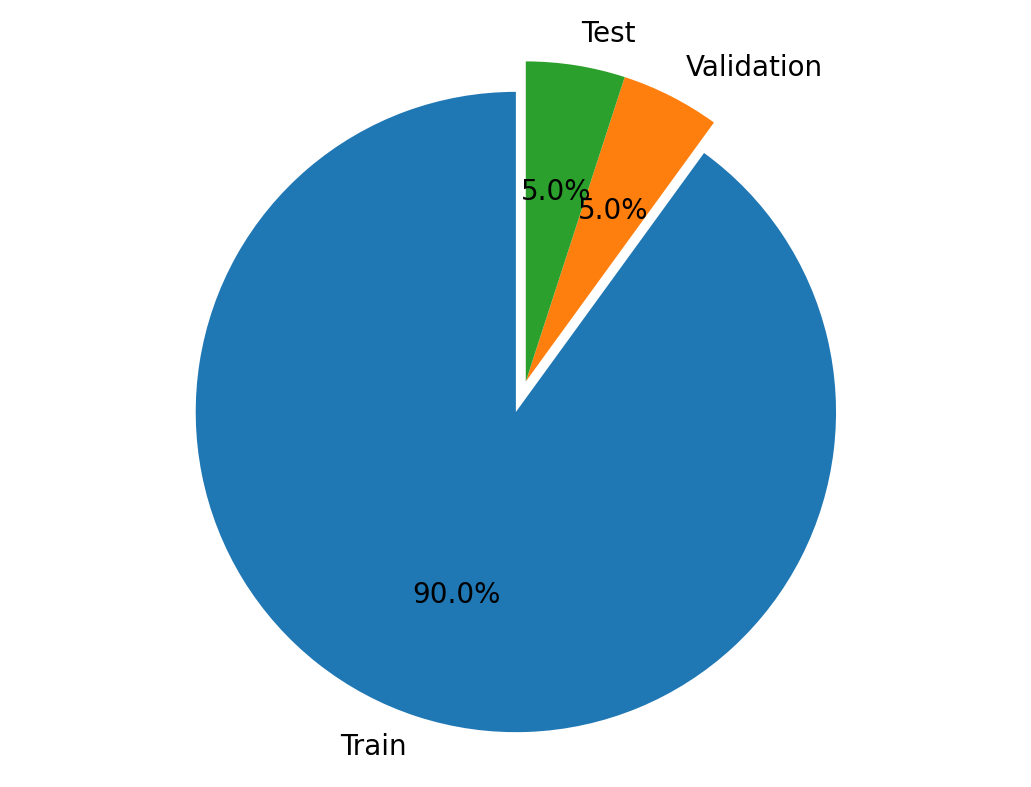

In [18]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train Data Split

In [19]:
df_train.shape

(900, 15)

<AxesSubplot:title={'center':'90% Train Breakdown by Star Rating'}, xlabel='star_rating'>

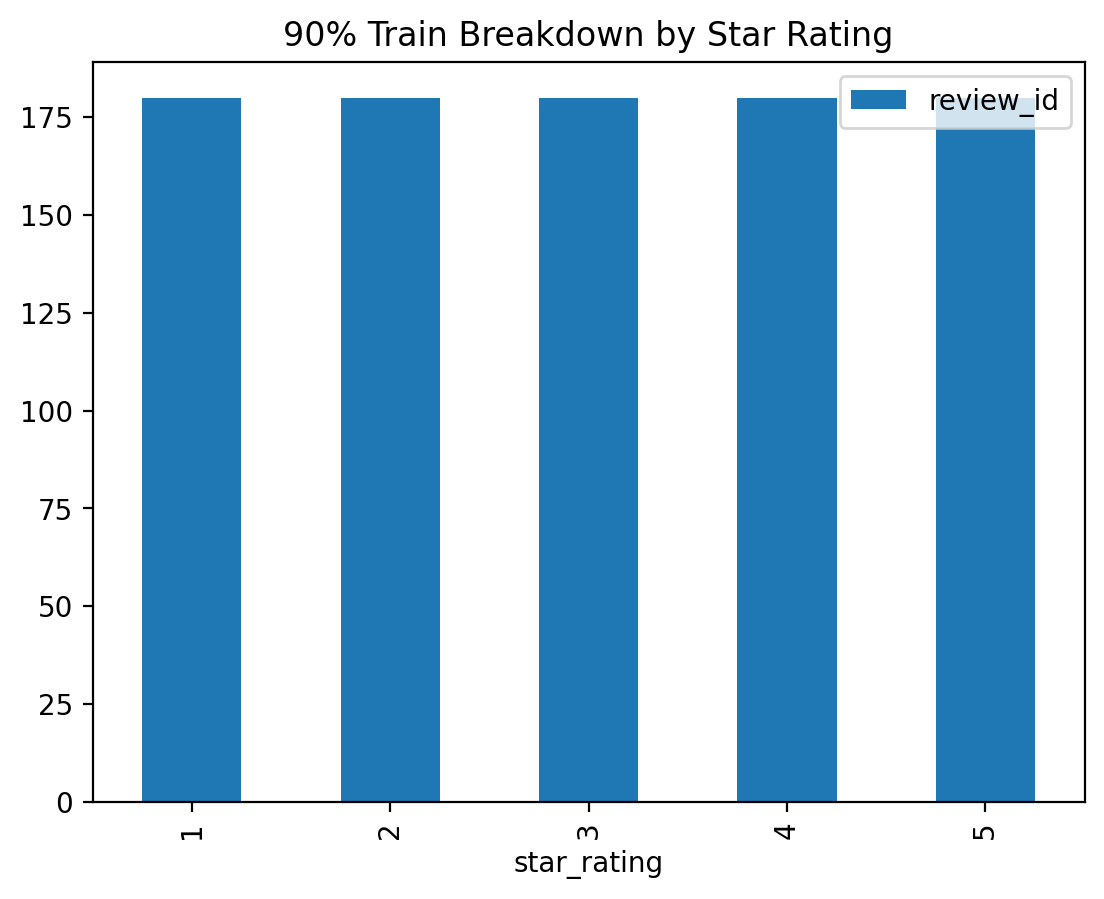

In [20]:
df_train[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="90% Train Breakdown by Star Rating"
)

# Show 5% Validation Data Split

In [21]:
df_validation.shape

(50, 15)

<AxesSubplot:title={'center':'5% Validation Breakdown by Star Rating'}, xlabel='star_rating'>

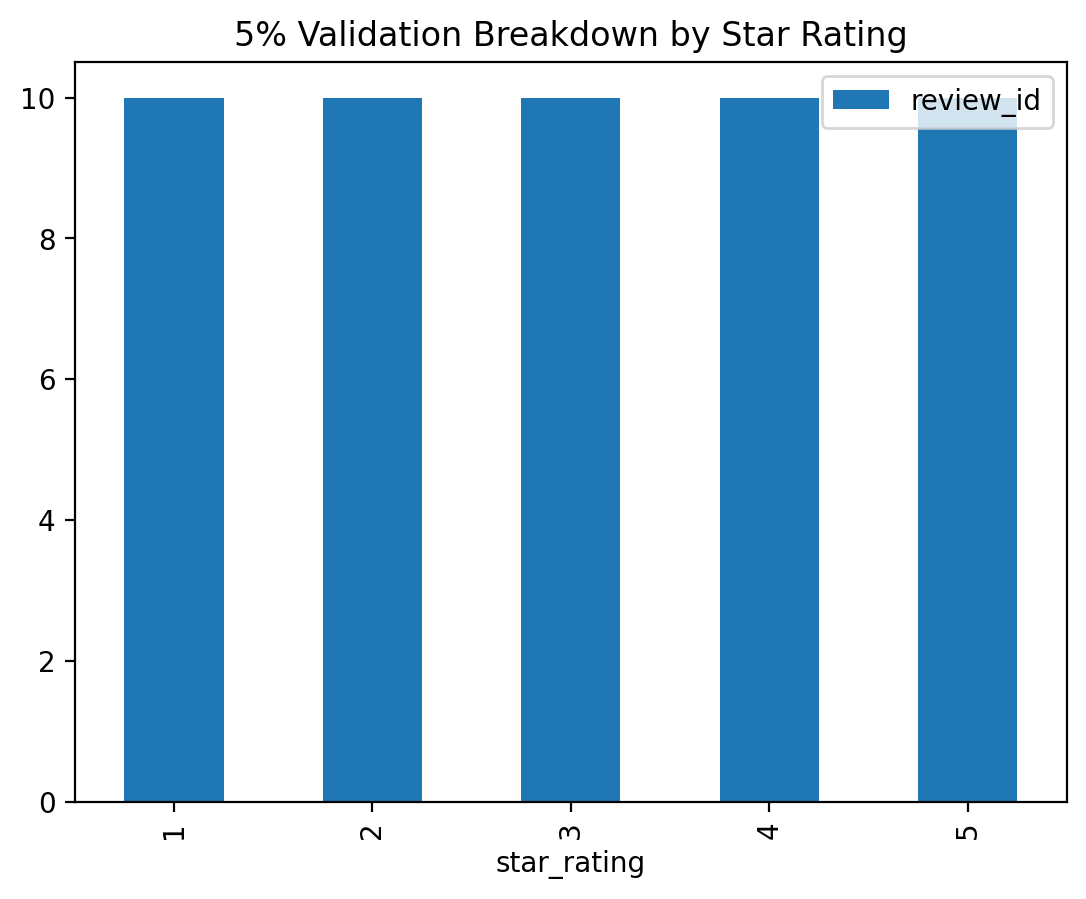

In [22]:
df_validation[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Validation Breakdown by Star Rating"
)

# Show 5% Test Data Split

In [23]:
df_test.shape

(50, 15)

<AxesSubplot:title={'center':'5% Test Breakdown by Star Rating'}, xlabel='star_rating'>

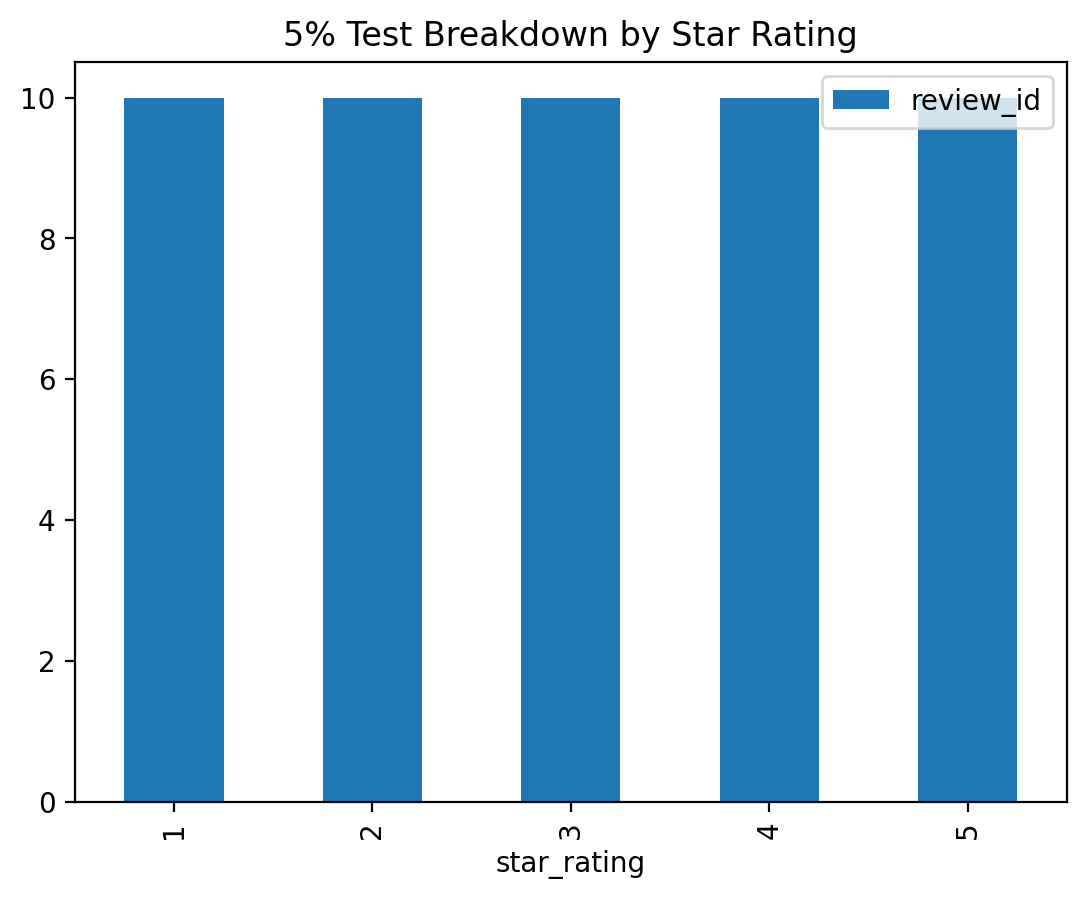

In [24]:
df_test[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Test Breakdown by Star Rating"
)

# Select `star_rating` and `review_body` for Training

In [25]:
df_train = df_train[["star_rating", "review_body"]]
df_train.shape

(900, 2)

In [26]:
df_train.head(5)

,star_rating,review_body
971,5,Download was quick and easy. I've only had it ...
555,3,I have been using Quicken Essentials for Mac a...
3,1,Wish there was a zero star rating. I had Offi...
132,1,Those of you experimenting with Windows 8 rele...
201,2,the State download was hard to install it keep...


# Write a CSV With No Header for Comprehend 

In [27]:
comprehend_train_path = f"{temp_folder}/{dataset_csv}"
df_train.to_csv(comprehend_train_path, index=False, header=False)

# Upload Train Data to S3 for Comprehend

In [28]:
train_s3_prefix = "data"
comprehend_train_s3_uri = sm.upload_data(path=comprehend_train_path, key_prefix=train_s3_prefix)
comprehend_train_s3_uri

's3://sagemaker-us-east-1-688013747199/data/amazon_reviews_us_Digital_Software_v1_00_comprehend.csv'

In [29]:
!aws s3 ls $comprehend_train_s3_uri

2022-11-15 18:57:23     411440 amazon_reviews_us_Digital_Software_v1_00_comprehend.csv


# Store the location of our train data in our notebook server to be used next

In [30]:
%store comprehend_train_s3_uri

Stored 'comprehend_train_s3_uri' (str)


In [31]:
%store

Stored variables and their in-db values:
comprehend_train_s3_uri               -> 's3://sagemaker-us-east-1-688013747199/data/amazon
role_arn                              -> 'arn:aws:iam::688013747199:role/sagemaker-vanilla-
role_name                             -> 'sagemaker-vanilla-SageMakerExecutionRole-A9Y6X9M9
setup_dependencies_passed             -> True
setup_iam_roles_passed                -> True


# Release Resources

In [32]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

In [33]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>